In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#% matplotlib inline
from datetime import datetime

import plotly.graph_objs as go
import plotly.offline as pyo
import plotly.figure_factory as ff
import plotly.express as px
from plotly import tools
from plotly.subplots import make_subplots
from plotly.offline import iplot

from textblob import TextBlob, Word, Blobber
from textblob.classifiers import NaiveBayesClassifier
from textblob.taggers import NLTKTagger

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer 
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
nltk.download('maxent_ne_chunker')
nltk.download('words')

import string
import gensim
import collections
from gensim.corpora import Dictionary

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

from autocorrect import Speller

from bs4 import BeautifulSoup
import requests
import csv
import time

import re
import string
import gc
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/aditidutta/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/aditidutta/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/aditidutta/nltk_data...
[nltk_data]   Package words is already up-to-date!


#### Using the arXiv API

In [2]:
import requests 
import datetime as dt
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

In [3]:
# Parameters
query = '(misogyny OR sexism OR sexist OR gender OR "online hate" OR "online abuse") AND ("social media" OR "social platform" OR twitter OR facebook OR reddit OR instagram OR meta OR linkedin OR youtube)' 
# original query only gave 22 results. This gives 405 results
max_results = 1000

In [4]:
#Call arXiv API with the query parameters
url = f'http://export.arxiv.org/api/query?search_query={query}&max_results={max_results}'
resp = requests.get(url)

In [5]:
# Parse the response.
# The response is in XML format. We’ll use an XML parser to parse the response
ns = { 'r':'http://www.w3.org/2005/Atom'}
root = ET.fromstring(resp.text)

# Construct the dataframe from the response
all_papers = list()
entries = root.findall('r:entry',namespaces=ns)
for entry in entries :
    all_papers.append({l.tag[l.tag.index('}')+1:] :l.text for l in entry})

all_papers_df=pd.DataFrame(all_papers)
all_papers_df.columns

Index(['id', 'updated', 'published', 'title', 'summary', 'author', 'comment',
       'link', 'primary_category', 'category', 'doi', 'journal_ref'],
      dtype='object')

In [6]:
len(all_papers_df)

405

In [7]:
# Joining the titles and the abstracts 
all_papers_df['title & abstract'] = all_papers_df['title'] + ' ' + all_papers_df['summary']

# Converting to datetime format
all_papers_df['year'] = pd.to_datetime(all_papers_df['published']).dt.year

In [8]:
# Removing dates till 2012 in post-filtering as only 'updated' and 'published' parameters are there
all_papers_df = all_papers_df[all_papers_df.year > 2012]

In [9]:
import datetime
%time
def initial_process(df):
    data = df.copy()
    data = data[~data['summary'].isnull()]  # Remove rows with empty content

    # Select contents of length between 140 and 2000 characters.
    data = data[(data.summary.map(len) > 140) & (data.summary.map(len) <= 2000)]
    data.reset_index(inplace=True, drop=True)

    # collecting 10000 random sample for computational ease
    #data = data.sample(10000, random_state=2021)
    #data.reset_index(inplace=True, drop=True)
    

    # aligning the columns in order of requirement
    data = data[['year', 'title', 'summary']]
    # renaming date -> date_of_news
    #data.rename(columns = {'date': 'date_of_news'}, inplace = True)
    return (data)

data = initial_process(all_papers_df)
data.tail(3)

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 3.1 µs


,year,title,summary
396,2013,What are Chinese Talking about in Hot Weibos?,SinaWeibo is a Twitter-like social network s...
397,2016,Surveying Turkish high school and university s...,Student attitudes and approaches to problem ...
398,2020,Large image datasets: A pyrrhic win for comput...,In this paper we investigate problematic pra...


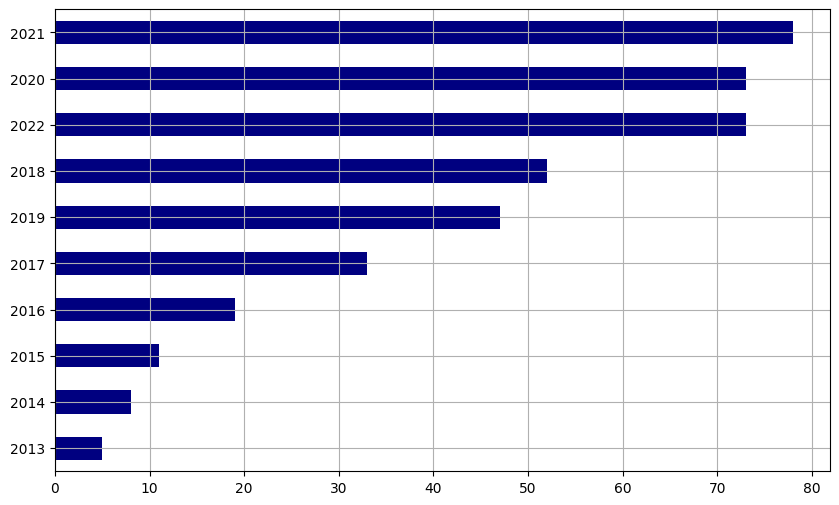

In [10]:
years = data['year'].value_counts().to_frame()[:30]
years.sort_values(by='year', ascending=True).plot(
    kind = 'barh', colormap='jet', legend=False, figsize=(10, 6));
plt.grid(True)

In [11]:
df_pub_years = pd.DataFrame({
    'year': data['year'].dropna().unique(),
    'count': data['year'].value_counts().tolist()
})
df_pub_years = df_pub_years.sort_values(by='year', ascending=True)
tick_val = df_pub_years.year.to_list()

fig = px.bar(df_pub_years, x="year", y="count", color= "count", 
            hover_data=['year'], text ='count')
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_traces(textposition='outside')
fig.update_layout(title_text='Number of preprints by years', title_x=0.5, title_y=0.92,
    showlegend=False)
fig.update_yaxes(range=[0,90])
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = tick_val,
        ticktext = tick_val
    )
)
fig.update_coloraxes(showscale=False)

fig.show()

### Further preprocessing

In [12]:
%time
def preProcess(text):
    #  Remove non-ASCII characters
    text = text.encode('ascii', 'ignore').decode('utf-8', 'ignore').lower()                   # lower case lowers the sparsity of the data
  
    # remove numbers
    text = re.sub(r'\d+', '', str(text))

    # removing salutaions (if any)
    text = re.sub("Mr\.",'Mr',  str(text))
    text = re.sub("Mrs\.",'Mrs',str(text))

    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r'won\'t', 'will not', text)
    text = text.replace('(ap)', '')
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r'(\w+)\'s', '\g<1> is', text)
    text = re.sub(r'(\w+)\'ve', '\g<1> have', text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)

   
    # substitute multiple whitespace with single whitespace
    # Also, removes leading and trailing whitespaces
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
  
    # removing any reference to outside text
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)

    text = text.strip()
    return text

# preprocessing texts
data['processedsummary'] = data['summary'].apply(preProcess)
data.head(3)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 2.15 µs


,year,title,summary,processedsummary
0,2021,Let-Mi: An Arabic Levantine Twitter Dataset fo...,Online misogyny has become an increasing wor...,online misogyny has become an increasing worry...
1,2022,SexWEs: Domain-Aware Word Embeddings via Cross...,The goal of sexism detection is to mitigate ...,the goal of sexism detection is to mitigate ne...
2,2017,Wearing Many (Social) Hats: How Different are ...,This paper investigates when users create pr...,this paper investigates when users create prof...


##### Removing rare words

In [13]:
%time
num_of_rare_words = 25
RARE_WORDS = set([w for (w, wc) in collections.Counter().most_common()[:-num_of_rare_words-1:-1]])
def remove_rare_words(text):
    return " ".join([word for word in str(text).split() if word not in RARE_WORDS])

data["processedsummary"] = data["processedsummary"].apply(lambda text: remove_rare_words(text))
data.head(3)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 2.15 µs


,year,title,summary,processedsummary
0,2021,Let-Mi: An Arabic Levantine Twitter Dataset fo...,Online misogyny has become an increasing wor...,online misogyny has become an increasing worry...
1,2022,SexWEs: Domain-Aware Word Embeddings via Cross...,The goal of sexism detection is to mitigate ...,the goal of sexism detection is to mitigate ne...
2,2017,Wearing Many (Social) Hats: How Different are ...,This paper investigates when users create pr...,this paper investigates when users create prof...


##### Frequent words removal

In [14]:
%time
FREQ_WORDS = set([w for (w, wc) in collections.Counter().most_common(25)])
def remove_freq_words(text):
    return " ".join([word for word in str(text).split() if word not in FREQ_WORDS])

data["processedsummary"] = data["processedsummary"].apply(lambda text: remove_freq_words(text))
data.head(3)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 1.91 µs


,year,title,summary,processedsummary
0,2021,Let-Mi: An Arabic Levantine Twitter Dataset fo...,Online misogyny has become an increasing wor...,online misogyny has become an increasing worry...
1,2022,SexWEs: Domain-Aware Word Embeddings via Cross...,The goal of sexism detection is to mitigate ...,the goal of sexism detection is to mitigate ne...
2,2017,Wearing Many (Social) Hats: How Different are ...,This paper investigates when users create pr...,this paper investigates when users create prof...


##### Stopwords removal

In [15]:
%time

stop_words = set(stopwords.words('english'))

# add words that aren't in the NLTK stopwords list
STOPWORDS = list(stop_words)
#print(STOPWORDS); print()
#print(len(STOPWORDS))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

data["processedsummary"] = data["processedsummary"].apply(lambda text: remove_stopwords(text))
data.head(5)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 2.15 µs


,year,title,summary,processedsummary
0,2021,Let-Mi: An Arabic Levantine Twitter Dataset fo...,Online misogyny has become an increasing wor...,online misogyny become increasing worry arab w...
1,2022,SexWEs: Domain-Aware Word Embeddings via Cross...,The goal of sexism detection is to mitigate ...,goal sexism detection mitigate negative online...
2,2017,Wearing Many (Social) Hats: How Different are ...,This paper investigates when users create pr...,paper investigates users create profiles diffe...
3,2019,When a Tweet is Actually Sexist. A more Compre...,Sexism is very common in social media and ma...,sexism common social media makes boundaries fr...
4,2019,How is Your Mood When Writing Sexist tweets? D...,Online social platforms have been the battle...,online social platforms battlefield users diff...


##### Lemmatizing

In [16]:
wnl = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([wnl.lemmatize(word) for word in text.split()])

data["processedsummary"] = data["processedsummary"].apply(lambda text: lemmatize_words(text))
data.head()

,year,title,summary,processedsummary
0,2021,Let-Mi: An Arabic Levantine Twitter Dataset fo...,Online misogyny has become an increasing wor...,online misogyny become increasing worry arab w...
1,2022,SexWEs: Domain-Aware Word Embeddings via Cross...,The goal of sexism detection is to mitigate ...,goal sexism detection mitigate negative online...
2,2017,Wearing Many (Social) Hats: How Different are ...,This paper investigates when users create pr...,paper investigates user create profile differe...
3,2019,When a Tweet is Actually Sexist. A more Compre...,Sexism is very common in social media and ma...,sexism common social medium make boundary free...
4,2019,How is Your Mood When Writing Sexist tweets? D...,Online social platforms have been the battle...,online social platform battlefield user differ...


##### Remove punctuations

In [17]:
%time
PUNCT_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_REMOVE))

data["processedsummary"] = data["processedsummary"].apply(lambda text: remove_punctuation(text))
data.head()


CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 2.15 µs


,year,title,summary,processedsummary
0,2021,Let-Mi: An Arabic Levantine Twitter Dataset fo...,Online misogyny has become an increasing wor...,online misogyny become increasing worry arab w...
1,2022,SexWEs: Domain-Aware Word Embeddings via Cross...,The goal of sexism detection is to mitigate ...,goal sexism detection mitigate negative online...
2,2017,Wearing Many (Social) Hats: How Different are ...,This paper investigates when users create pr...,paper investigates user create profile differe...
3,2019,When a Tweet is Actually Sexist. A more Compre...,Sexism is very common in social media and ma...,sexism common social medium make boundary free...
4,2019,How is Your Mood When Writing Sexist tweets? D...,Online social platforms have been the battle...,online social platform battlefield user differ...


##### Tokenization

In [18]:
# tokenizer to 'processedContent' column through all rows and store in 'tokens' column.
data['tokens'] = data['processedsummary'].apply(word_tokenize) 

#  POS tagging of the sentence and ne_chunk() to recognize each named entity in sentences
data['ner'] = data['processedsummary']\
    .apply(lambda x: nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(x)),binary=True))
data.tail(3)

,year,title,summary,processedsummary,tokens,ner
396,2013,What are Chinese Talking about in Hot Weibos?,SinaWeibo is a Twitter-like social network s...,sinaweibo twitter like social network service ...,"[sinaweibo, twitter, like, social, network, se...","[(sinaweibo, JJ), (twitter, NN), (like, IN), (..."
397,2016,Surveying Turkish high school and university s...,Student attitudes and approaches to problem ...,student attitude approach problem solving impa...,"[student, attitude, approach, problem, solving...","[(student, NN), (attitude, NN), (approach, NN)..."
398,2020,Large image datasets: A pyrrhic win for comput...,In this paper we investigate problematic pra...,paper investigate problematic practice consequ...,"[paper, investigate, problematic, practice, co...","[(paper, NN), (investigate, NN), (problematic,..."


### Term Document Frequency

In [19]:
%time
yDf = data[['year', 'title', 'tokens']].copy()

bigram = gensim.models.Phrases(yDf['tokens'], min_count=5, threshold=100)
bigramModel = gensim.models.phrases.Phraser(bigram)

yDf['bigramTokens'] = yDf['tokens'].progress_map(lambda tokens: bigramModel[tokens])

# Creating Dictionary
id2word = Dictionary(yDf['bigramTokens'])

# Creating Corpus
texts = yDf['bigramTokens'].tolist()
dictionary = Dictionary(texts)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

CPU times: user 1e+03 ns, sys: 3 µs, total: 4 µs
Wall time: 12.9 µs


progress-bar: 100%|██████████| 399/399 [00:00<00:00, 17164.38it/s]


### Defining LDA model

CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 12.2 µs


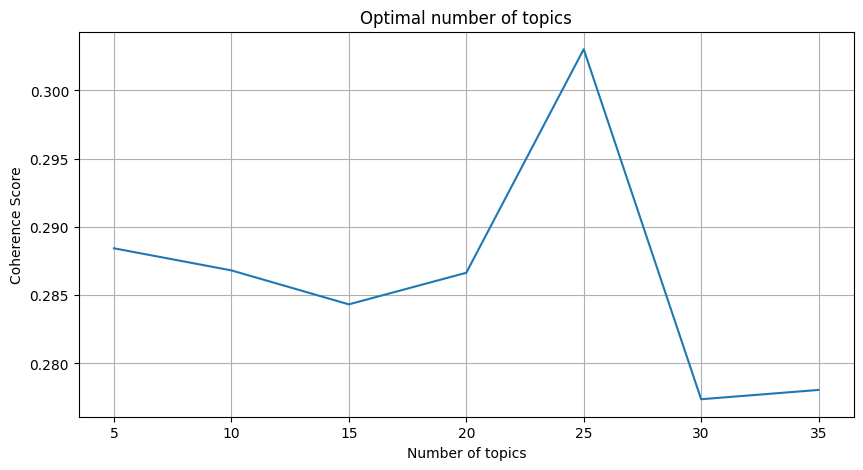

In [20]:

%time

# Define LDA model in function that takes the number of topics as a parameter.
def LDAmodel(num_topics, passes=1):
    return gensim.models.ldamodel.LdaModel(
        corpus=tqdm(corpus, leave=False),
        id2word=id2word,
        alpha='auto', eta='auto',
        num_topics=num_topics, # the number of topics is equal to num_topics
        random_state=2021,
        eval_every=1,
        chunksize=2000,
        passes=passes,
        per_word_topics=True
        )
    
def coherence_computation(model):
    coherence = CoherenceModel(
        model = model, 
        texts = texts,
        dictionary = id2word, coherence='c_v'
        )
    return coherence.get_coherence()

def display_topics(model):
    topics = model.show_topics(num_topics=model.num_topics, formatted=False, num_words=10)
    topics = map(lambda c: map(lambda cc: cc[0], c[1]), topics)
    DATA = pd.DataFrame(topics)
    DATA.index = ['topic_{0}'.format(i) for i in range(model.num_topics)]
    DATA.columns = ['keyword_{0}'.format(i) for i in range(1, 10+1)]
    return DATA

def explore_models(DATA, range = range(5, 25)):
    id2word = Dictionary(DATA['bigramTokens'])
    texts = DATA['bigramTokens'].tolist()
    corpus = [id2word.doc2bow(text) for text in texts]

    coherence_values = []
    model_list = []
    
    for num_topics in tqdm(range, leave=False):
        lda = LDAmodel(num_topics, passes=5)
        model_list.append(lda)
        coherence = coherence_computation(lda)
        coherence_values.append(coherence)
      
    fig = plt.figure(figsize=(10,5))
    plt.title('Optimal number of topics')
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence Score')
    plt.grid(True)
    plt.plot(range, coherence_values)
    
    return coherence_values, model_list

coherence_values, model_list = explore_models(yDf, range = range(5, 40, 5))

##### Printing the coherence scores

In [21]:
# Print the coherence scores
limit=40; start=5; step=6;
x = range(start, limit, step)

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.2884
Num Topics = 11  has Coherence Value of 0.2868
Num Topics = 17  has Coherence Value of 0.2843
Num Topics = 23  has Coherence Value of 0.2866
Num Topics = 29  has Coherence Value of 0.303
Num Topics = 35  has Coherence Value of 0.2774


In [22]:
pd.options.display.max_columns = 20
bestModel = LDAmodel(num_topics=10, passes=5)
print(display_topics(model = bestModel))

           keyword_1 keyword_2 keyword_3    keyword_4    keyword_5 keyword_6  \
topic_0        model    social    sexism         task       gender  language   
topic_1         user    social    gender         data       medium     model   
topic_2       social      name   network       gender      student      user   
topic_3       gender      bias     study       online  hate_speech    social   
topic_4       social    online    medium       gender         user   network   
topic_5         user    gender     model  hate_speech       social      data   
topic_6  hate_speech    social    online       medium     approach      user   
topic_7        tweet    social  research        group       gender     model   
topic_8       gender      data      bias    algorithm    different     model   
topic_9       gender     image    social       medium        covid     paper   

           keyword_7 keyword_8 keyword_9   keyword_10  
topic_0       medium      data   dataset        tweet  
topic_1